# CASL Fuel assembly 2B

# Import modules

In [1]:
import openmc
import openmc.mgxs as mgxs

import numpy as np
import matplotlib.pyplot as plt

# Add location of OpenMC XS executable, setup ENDF xs path

In [2]:
import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml

env: OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml


# Start model

In [3]:
model = openmc.Model()

# Define Materials

In [4]:
uo2 = openmc.Material(name='uo2')

uo2.add_nuclide('U234', 6.11864E-06, 'ao')
uo2.add_nuclide('U235', 7.18132E-04, 'ao')
uo2.add_nuclide('U236', 3.29861E-06, 'ao')
uo2.add_nuclide('U238', 2.21546E-02, 'ao')
uo2.add_nuclide('O16', 4.57642E-02, 'ao')

uo2.set_density('g/cm3', 10.257 )

uo2.temperature = 600

In [5]:
zirconium = openmc.Material(name="zirconium")

zirconium.add_nuclide('Zr90', 2.18865E-02, 'ao')
zirconium.add_nuclide('Zr91', 4.77292E-03, 'ao')
zirconium.add_nuclide('Zr92', 7.29551E-03, 'ao')
zirconium.add_nuclide('Zr94', 7.39335E-03, 'ao')
zirconium.add_nuclide('Zr96', 1.19110E-03, 'ao')
zirconium.add_nuclide('Sn112',4.68066E-06, 'ao')
zirconium.add_nuclide('Sn114', 3.18478E-06, 'ao')
zirconium.add_nuclide('Sn115', 1.64064E-06, 'ao')
zirconium.add_nuclide('Sn116', 7.01616E-05, 'ao')
zirconium.add_nuclide('Sn117', 3.70592E-05, 'ao')
zirconium.add_nuclide('Sn118', 1.16872E-04, 'ao')
zirconium.add_nuclide('Sn119', 4.14504E-05, 'ao')
zirconium.add_nuclide('Sn120', 1.57212E-04, 'ao')
zirconium.add_nuclide('Sn122', 2.23417E-05, 'ao')
zirconium.add_nuclide('Sn124', 2.79392E-05, 'ao')
zirconium.add_nuclide('Fe54', 8.68307E-06, 'ao')
zirconium.add_nuclide('Fe56', 1.36306E-04, 'ao')
zirconium.add_nuclide('Fe57', 3.14789E-06, 'ao')
zirconium.add_nuclide('Fe58', 4.18926E-07, 'ao')
zirconium.add_nuclide('Cr50', 3.30121E-06, 'ao')
zirconium.add_nuclide('Cr52', 6.36606E-05, 'ao')
zirconium.add_nuclide('Cr53', 7.21860E-06, 'ao')
zirconium.add_nuclide('Cr54', 1.79686E-06, 'ao')
zirconium.add_nuclide('Hf174', 3.54138E-09, 'ao')
zirconium.add_nuclide('Hf176', 1.16423E-07, 'ao')
zirconium.add_nuclide('Hf177', 4.11686E-07, 'ao')
zirconium.add_nuclide('Hf178', 6.03806E-07, 'ao')
zirconium.add_nuclide('Hf179', 3.01460E-07, 'ao')
zirconium.add_nuclide('Hf180', 7.76449E-07, 'ao')

zirconium.set_density('g/cm3',  6.56)

zirconium.temperature = 600

In [6]:
water = openmc.Material(name="water")

water.add_nuclide('H1',4.96224E-02, 'ao')
water.add_nuclide('O16', 2.48112E-02, 'ao')
water.add_nuclide('B10', 1.07070E-05, 'ao')
water.add_nuclide('B11', 4.30971E-05, 'ao')

water.add_s_alpha_beta('c_H_in_H2O')

water.set_density('g/cm3', 0.661)

water.temperature = 600

In [7]:
helium = openmc.Material(name="helium")

helium.add_nuclide('He4',1, 'ao')

helium.set_density('g/cm3', 0.178E-03 )

helium.temperature = 600

### do not do this here because of cloning later on

In [8]:
# model.materials = openmc.Materials([uo2, zirconium, water,helium]) 

# print(model.materials)

# Defining individiual cells

In [9]:
pitch = 1.26

### Planes used to define cells

In [10]:
left   = openmc.XPlane(-pitch/2, boundary_type='transmission')
right  = openmc.XPlane( pitch/2, boundary_type='transmission')
bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
top    = openmc.YPlane( pitch/2, boundary_type='transmission')

### Create fuel pin: fuel, clad, water

In [11]:
def pin_cell_universe(family):
    fuel_outer_radius = openmc.ZCylinder(r=0.4096)
    gap_inner_radius  = openmc.ZCylinder(r=0.418)
    clad_outer_radius = openmc.ZCylinder(r=0.475)

    fuel_region  = -fuel_outer_radius
    gap_region   = +fuel_outer_radius & -gap_inner_radius
    clad_region  = +gap_inner_radius  & -clad_outer_radius
    water_region = +clad_outer_radius & +left & -right & +bottom & -top

    fuel = openmc.Cell(name=family+'-fuel')
    fuel.region = fuel_region
    new_fuel = uo2.clone()
    fuel.fill = new_fuel

    gap = openmc.Cell(name=family+'-gap')
    gap.region = gap_region
    gap.fill = helium     

    clad = openmc.Cell(name=family+'-clad')
    clad.fill = zirconium
    clad.region = clad_region

    moderator = openmc.Cell(name=family+'-moderator')
    moderator.fill = water
    moderator.region = water_region 

    return openmc.Universe(name=family+'-pin_univ', cells=(fuel, clad, moderator,gap)), new_fuel

### Create guide tube: water, clad, water

In [12]:
gt_inner_radius = openmc.ZCylinder(r=0.561)
gt_outer_radius = openmc.ZCylinder(r=0.602)

gt_water_in_region  = -gt_inner_radius
gt_clad_region      = +gt_inner_radius & -gt_outer_radius
gt_water_out_region = +gt_outer_radius & +left & -right & +bottom & -top

gt_water_in = openmc.Cell(name='gt-water-in')
gt_water_in.fill = water
gt_water_in.region = gt_water_in_region

gt_clad = openmc.Cell(name='gt-clad')
gt_clad.fill = zirconium
gt_clad.region = gt_clad_region

gt_water_out = openmc.Cell(name='gt-water-out')
gt_water_out.fill = water
gt_water_out.region = gt_water_out_region 

gt_univ = openmc.Universe(name='gt_univ', cells=(gt_water_in, gt_clad, gt_water_out))

### Create instrumentation tube: water, clad, water

In [13]:
it_inner_radius = openmc.ZCylinder(r=0.559)
it_outer_radius = openmc.ZCylinder(r=0.605)

it_water_in_region  = -it_inner_radius
it_clad_region      = +it_inner_radius & -it_outer_radius
it_water_out_region = +it_outer_radius & +left & -right & +bottom & -top

it_water_in = openmc.Cell(name='it-water-in')
it_water_in.fill = water
it_water_in.region = it_water_in_region

it_clad = openmc.Cell(name='it-clad')
it_clad.fill = zirconium
it_clad.region = it_clad_region

it_water_out = openmc.Cell(name='it-water-out')
it_water_out.fill = water
it_water_out.region = it_water_out_region 

it_univ = openmc.Universe(name='it_univ', cells=(it_water_in, it_clad, it_water_out))

## Read fuel assembly layout

In [14]:
import csv
from collections import Counter

def read_csv_to_2d_array(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        data = [row for row in reader]
    return np.asarray(data)

def count_frequencies(data):
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    print("cell name frequency:")
    total = 0
    for key, value in cell_frequencies.items():
        print(f'"{key}": {value}')
        total += value
    print("total: ",total)

def fuel_keys(data, exclude_keys=["gt","it"]):
    """
    Return a list of keys after excluding any keys found in 'exclude_keys'.
    
    Parameters:
        keys (list): List of keys to filter.
        exclude_keys (list): List of keys that should be excluded from the result.
    
    Returns:
        list: A new list with the keys not present in the exclude_keys list.
    """
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    keys = list(cell_frequencies.keys())
    return [key for key in keys if key not in exclude_keys]


In [15]:
file_path = 'FA_cell_names_7_families.csv'  # Change this to the actual path of your CSV file
file_path = 'FA_cell_names_1_family.csv'    # Change this to the actual path of your CSV file

# read cell names
FA_cell_names = read_csv_to_2d_array(file_path)
# print statistics
count_frequencies(FA_cell_names)

# check
if FA_cell_names.shape[0] != FA_cell_names.shape[1]:
    raise Exception('array of cell names is not square')
# number of fuel assembly per dimension
Nassy = FA_cell_names.shape[0] # size of the assembly 

# get fuel cell names
fuel_names = fuel_keys(FA_cell_names)
print("\nfuel names=",fuel_names)

cell name frequency:
"fu": 264
"gt": 24
"it": 1
total:  289

fuel names= ['fu']


## Create several fuel pin universes to handle the multiple fuel-MGXS to be generated

In [16]:
# list of material that will be used
material_list = [ helium, zirconium, water ]

pin_univ_clones = {}
for fuel_name in fuel_names:
    pin_univ_clones[fuel_name], new_fuel = pin_cell_universe(fuel_name)
    material_list.append(new_fuel)

In [17]:
model.materials = openmc.Materials(material_list) 

print(model.materials)

[Material
	ID             =	4
	Name           =	helium
	Temperature    =	600
	Density        =	0.000178 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	He4            =	1            [ao]
, Material
	ID             =	2
	Name           =	zirconium
	Temperature    =	600
	Density        =	6.56 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.0218865    [ao]
	Zr91           =	0.00477292   [ao]
	Zr92           =	0.00729551   [ao]
	Zr94           =	0.00739335   [ao]
	Zr96           =	0.0011911    [ao]
	Sn112          =	4.68066e-06  [ao]
	Sn114          =	3.18478e-06  [ao]
	Sn115          =	1.64064e-06  [ao]
	Sn116          =	7.01616e-05  [ao]
	Sn117          =	3.70592e-05  [ao]
	Sn118          =	0.000116872  [ao]
	Sn119          =	4.14504e-05  [ao]
	Sn120          =	0.000157212  [ao]
	Sn122          =	2.23417e-05  [ao]
	Sn124          =	2.79392e-05  [ao]
	Fe54           =	8.6830

In [18]:
uo2

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	600
	Density        =	10.257 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	6.11864e-06  [ao]
	U235           =	0.000718132  [ao]
	U236           =	3.29861e-06  [ao]
	U238           =	0.0221546    [ao]
	O16            =	0.0457642    [ao]

In [19]:
pin_univ_clones

{'fu': Universe
 	ID             =	3
 	Name           =	fu-pin_univ
 	Geom           =	CSG
 	Cells          =	[7, 9, 10, 8]}

# Lattice geometry

In [20]:
FA_lat = openmc.RectLattice()

FA_lat.pitch = (pitch, pitch)

FA_half_width = Nassy * pitch / 2

FA_lat.lower_left = (-FA_half_width, -FA_half_width)

### Fill in cells of fuel assembly

### caveat. user supplied bool in the cell below :  `one_eighth`

In [21]:
# either 1/8 or 1/4 of FA
one_eighth = True

In [22]:
# ndarray of type openmc Universe    
FA_univ_layout = np.empty((Nassy, Nassy), dtype = openmc.universe.Universe)

for i in range(Nassy):
    for j in range(Nassy):
        cellname = FA_cell_names[i,j]
        if cellname == 'gt':
            FA_univ_layout[i,j] = gt_univ
        elif cellname == 'it':
            FA_univ_layout[i,j] = it_univ
        elif cellname in fuel_names:
            FA_univ_layout[i,j] = pin_univ_clones[cellname]            
        else:
            mesg = 'i={},j={},cell-name {} not recognized'.format(i, j, cellname)
            raise ValueError(mesg)

# assign universes
FA_lat.universes = FA_univ_layout

# create cell that will contain the lattice
moderator_outside_cell = openmc.Cell( name = 'water_outside', fill = water )

FA_lat.outer = openmc.Universe( name='outer', cells = [moderator_outside_cell] )

# height
FA_height = 10.
# half of the inter fuel assembly water gap (half the spacing in between FAs)
dr2 = 0.04 


min_x = openmc.XPlane(x0= 0.               , boundary_type='reflective')
max_x = openmc.XPlane(x0= FA_half_width+dr2, boundary_type='reflective')
min_y = openmc.YPlane(y0= 0.               , boundary_type='reflective')
max_y = openmc.YPlane(y0= FA_half_width+dr2, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-FA_height/2      , boundary_type='reflective')
max_z = openmc.ZPlane(z0= FA_height/2      , boundary_type='reflective')
xy    = openmc.Plane(-1., 1.               , boundary_type='reflective')


# define root universe
root_cell = openmc.Cell( name = 'root cell', fill = FA_lat )

if one_eighth:
    root_cell.region = -max_x & +min_y & -xy
else:
    root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

### Plot

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

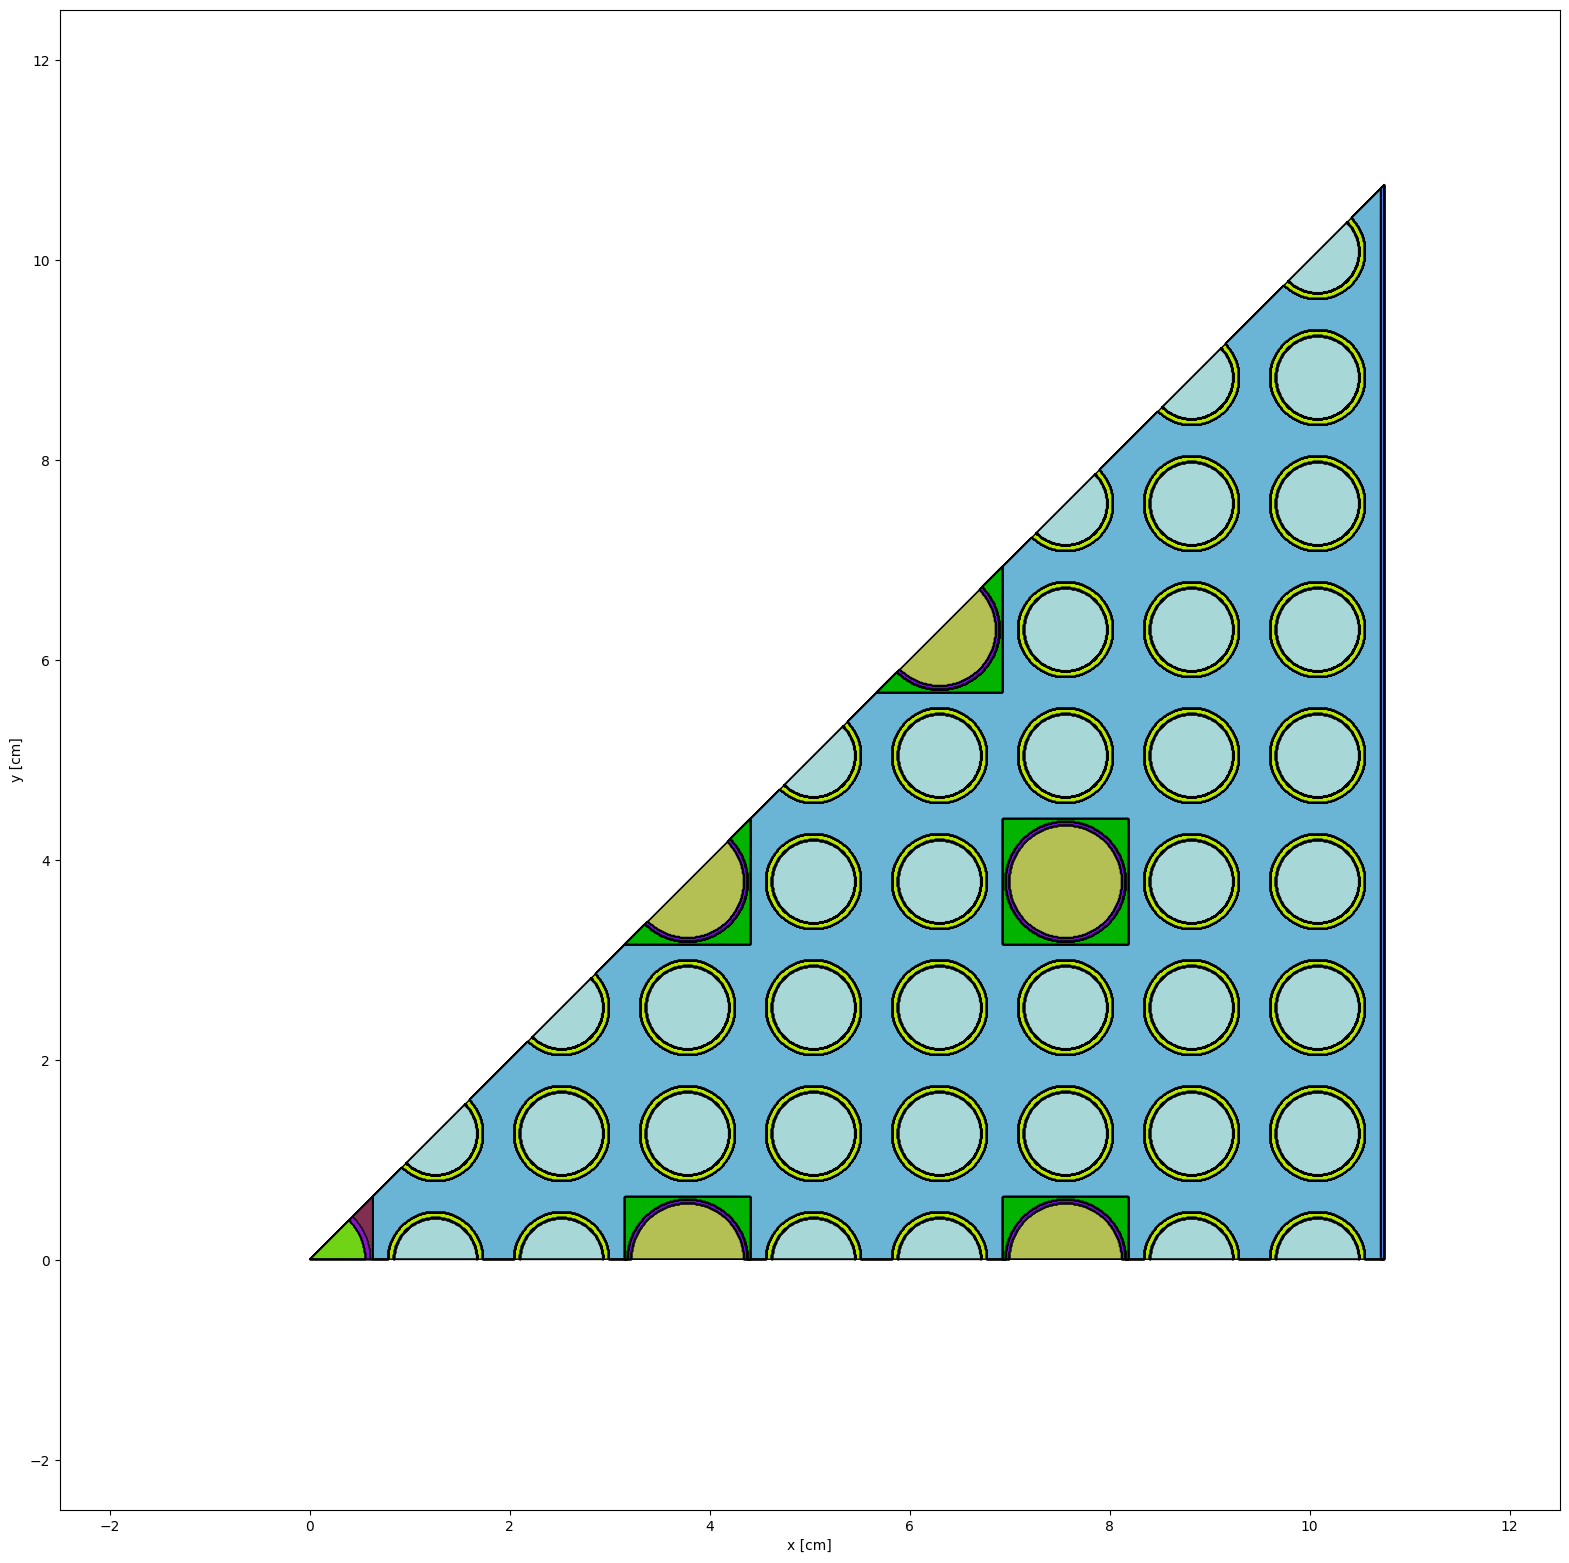

In [23]:
root_cell.plot(origin=(5,5,0), pixels=(1500,1500), width=(15,15),color_by='cell',outline=True)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

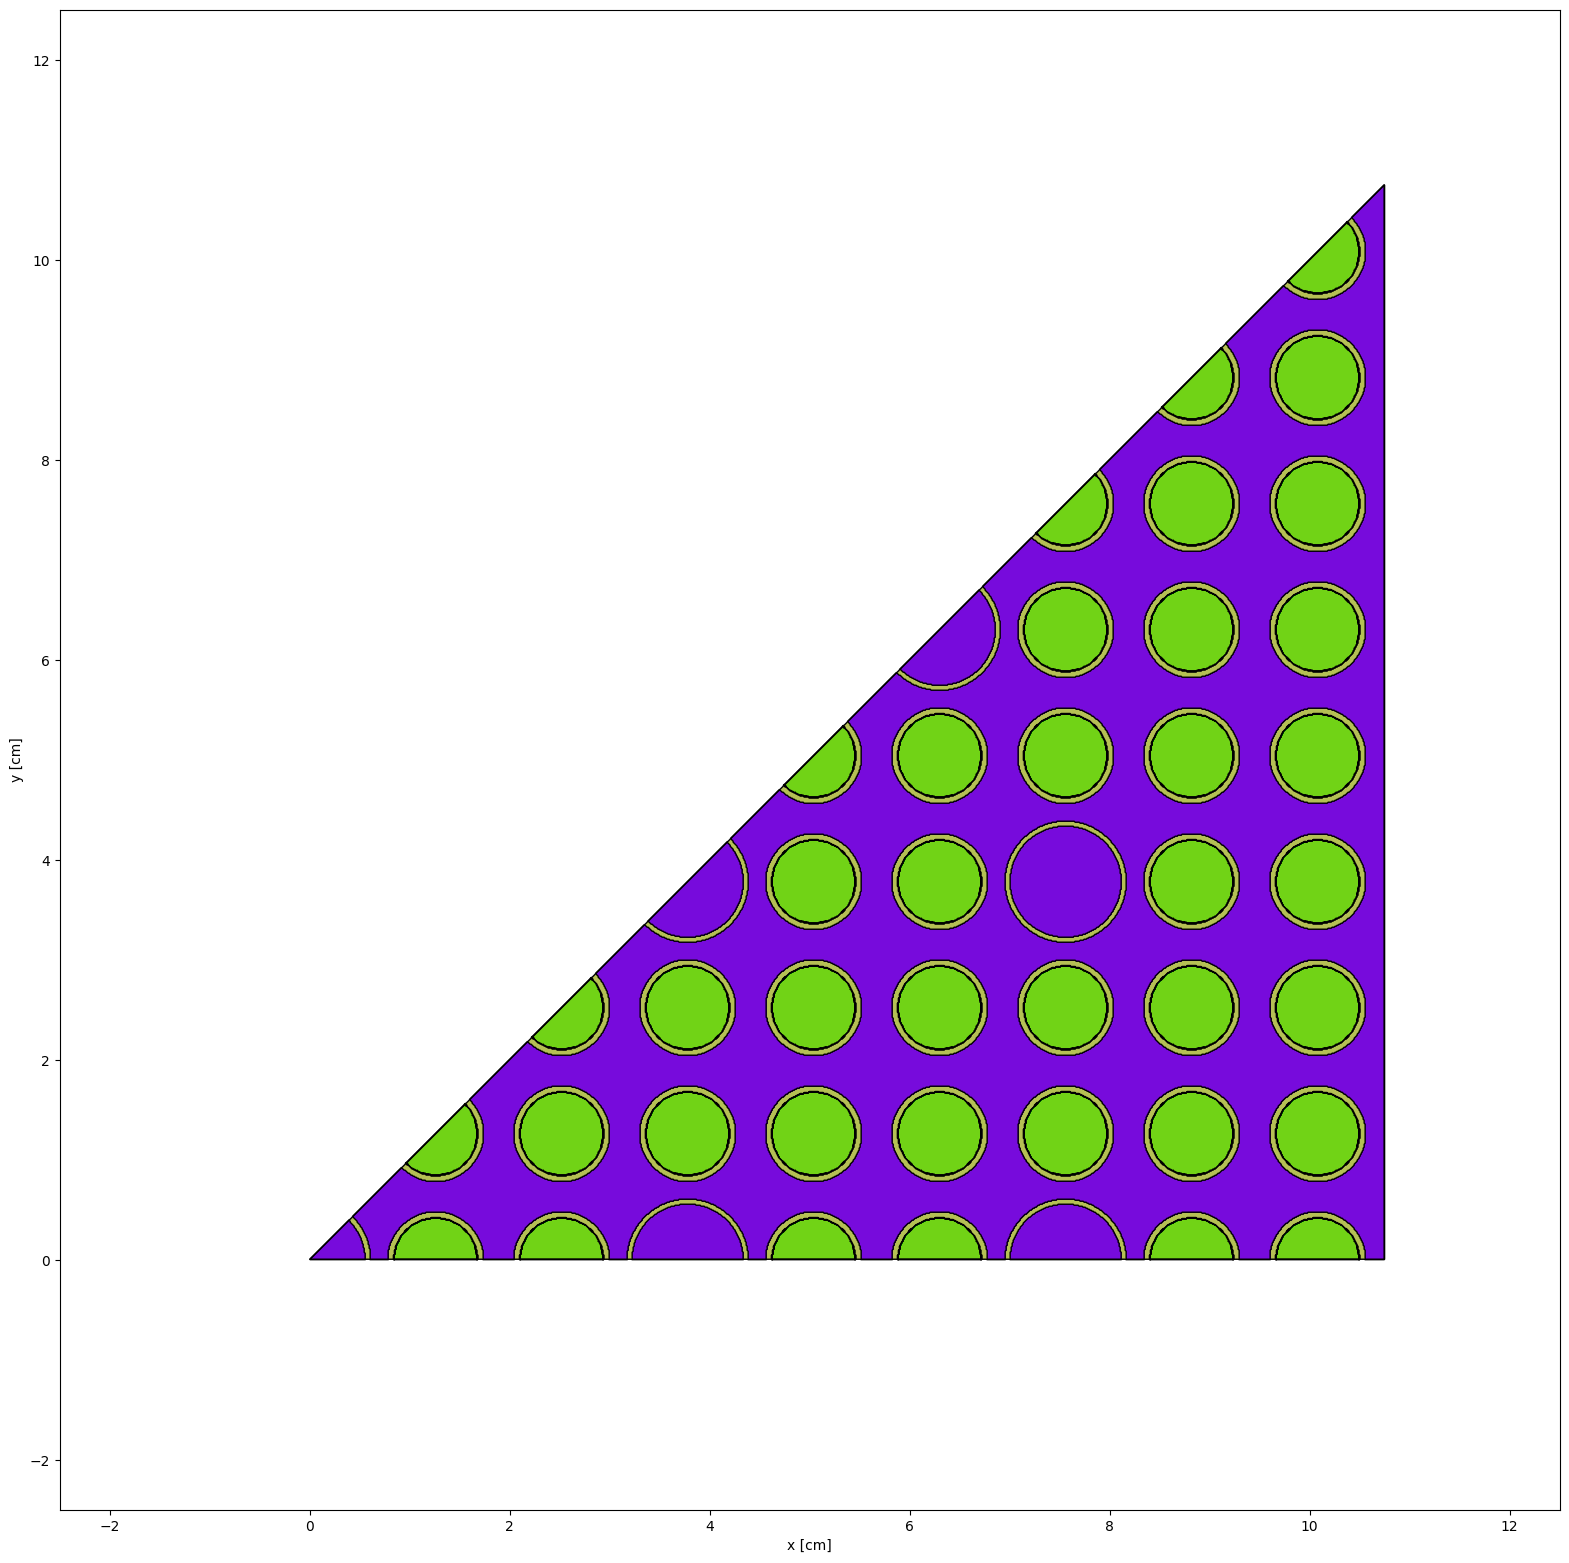

In [24]:
root_cell.plot(origin=(5,5,0), pixels=(1500,1500), width=(15,15),color_by='material', outline=True)

In [25]:
model.geometry.root_universe = openmc.Universe(name = 'root universe', cells=[root_cell])

### Source

In [26]:
model.geometry.bounding_box

BoundingBox(lower_left=(-inf, 0.0, -inf), upper_right=(10.75, inf, inf))

In [27]:
bbox = openmc.BoundingBox(lower_left  = [0., 0., -FA_height/2], \
                          upper_right = [FA_half_width, FA_half_width, FA_height/2])
print(bbox)

BoundingBox(lower_left=(0.0, 0.0, -5.0), upper_right=(10.71, 10.71, 5.0))


In [28]:
uniform_dist = openmc.stats.Box(bbox.lower_left, bbox.upper_right, only_fissionable=True)

source = openmc.IndependentSource(space=uniform_dist)

###  Settings

### caveat: destination folder supplied here

In [29]:
# instantitate settings object
settings = openmc.Settings()

# add source
settings.source = source

# add additional parameters
settings.batches =  150
settings.inactive = 20
settings.particles = 50000
settings.keff_trigger = {'type':'std_dev','threshold':0.00010}
settings.trigger_active = True
settings.trigger_max_batches = 50000
# settings.output = {'tallies':True}
settings.temperature['method'] = 'interpolation'

my_case = '2B'
my_path = './mgxs_casl_' + my_case
settings.output = {'tallies': True, 'path':my_path}

model.settings = settings

In [30]:
# check if folder exists
import pathlib
path = pathlib.Path(my_path)
path.mkdir(parents = True, exist_ok = True)

### Choose energy group

In [31]:
my_path

'./mgxs_casl_2B'

In [32]:
# egroup_name = 'XMAS-172'
egroup_name = 'SHEM-361'
egroup = openmc.mgxs.GROUP_STRUCTURES[egroup_name]

### Create MGXS tallies for mgxs directory

In [33]:
tally_power = openmc.Tally(name='power')

# Instantiate a tally Mesh
mesh = openmc.RegularMesh()
mesh._dimension = [17, 17]
mesh._lower_left = [-FA_half_width, -FA_half_width]
mesh._upper_right = [FA_half_width,FA_half_width]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

tally_power.scores = ['fission', 'nu-fission', 'kappa-fission']
tally_power.filters = [mesh_filter]

tallies = openmc.Tallies([tally_power])
# model.tallies=tallies

In [34]:
tally_by_cells = True

In [35]:
pn = 7
    
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(egroup)

mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission' ,'chi', \
                       'consistent nu-scatter matrix', 'multiplicity matrix','kappa-fission']

mgxs_lib.legendre_order = pn
if pn == 0:
    mgxs_lib.correction = None

mgxs_lib.by_nuclide = False

if tally_by_cells:
    # Specify a "cell" domain type for the cross section tally filters
    mgxs_lib.domain_type = 'cell'
    # Specify the cell domains over which to compute multi-group cross sections
    mgxs_lib.domains = model.geometry.get_all_material_cells().values()
else:
    mgxs_lib.domain_type = 'universe'
    mgxs_lib.domains = model.geometry.get_all_universes().values()
    
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()
mgxs_lib.check_library_for_openmc_mgxs()

# tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)

model.tallies = tallies

/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 7 is greater than zero
  warn(msg, RuntimeWarning)


### Export model

In [36]:
## model.export_to_model_xml('casl_2B.xml')

### Run OpenMC model

In [37]:
# trick to make several runs work with jupyter
try:
    sp 
    print('sp found')
    sp.close()
except NameError:
    print('sp NOT found')

sp NOT found


In [38]:
statepoint_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=401.
  warn(msg, IDWarning)
/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=11.
  warn(msg, IDWarning)


 Reading Zr90 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Zr90.h5
 Reading Zr91 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Zr91.h5
 Reading Zr92 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Zr92.h5
 Reading Zr94 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Zr94.h5
 Reading Zr96 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Zr96.h5
 Reading Sn112 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn112.h5
 Reading Sn114 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn114.h5
 Reading Sn115 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn115.h5
 Reading Sn116 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn116.h5
 Reading Sn117 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn117.h5
 Reading Sn118 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn118.h5
 Reading Sn119 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/neutron/Sn119.h5
 Reading Sn120 from /Users/jean.ragusa/repo/endfb-viii.0-hdf5/

      112/1    1.18219    1.18251 +/- 0.00075
      113/1    1.19162    1.18261 +/- 0.00075
      114/1    1.17681    1.18255 +/- 0.00074
      115/1    1.18158    1.18254 +/- 0.00073
      116/1    1.19661    1.18268 +/- 0.00074
      117/1    1.17063    1.18256 +/- 0.00074
      118/1    1.18237    1.18256 +/- 0.00074
      119/1    1.18128    1.18255 +/- 0.00073
      120/1    1.18368    1.18256 +/- 0.00072
      121/1    1.17456    1.18248 +/- 0.00072
      122/1    1.18002    1.18245 +/- 0.00071
      123/1    1.18087    1.18244 +/- 0.00070
      124/1    1.19411    1.18255 +/- 0.00071
      125/1    1.18472    1.18257 +/- 0.00070
      126/1    1.18742    1.18262 +/- 0.00069
      127/1    1.18186    1.18261 +/- 0.00069
      128/1    1.17957    1.18258 +/- 0.00068
      129/1    1.18512    1.18260 +/- 0.00068
      130/1    1.17123    1.18250 +/- 0.00068
      131/1    1.18558    1.18253 +/- 0.00067
      132/1    1.17439    1.18246 +/- 0.00067
      133/1    1.18429    1.18247 

      190/1    1.18609    1.18247 +/- 0.00051
 Triggers unsatisfied, max unc./thresh. is 3.039002657392851 for eigenvalue
 The estimated number of batches is 1591
      191/1    1.18182    1.18246 +/- 0.00051
 Triggers unsatisfied, max unc./thresh. is 3.0237755181947565 for eigenvalue
 The estimated number of batches is 1584
      192/1    1.19121    1.18251 +/- 0.00051
 Triggers unsatisfied, max unc./thresh. is 3.0074392436054453 for eigenvalue
 The estimated number of batches is 1576
      193/1    1.19273    1.18257 +/- 0.00051
 Triggers unsatisfied, max unc./thresh. is 2.9985196123838143 for eigenvalue
 The estimated number of batches is 1576
      194/1    1.18983    1.18262 +/- 0.00051
 Triggers unsatisfied, max unc./thresh. is 2.9982923585731798 for eigenvalue
 The estimated number of batches is 1585
      195/1    1.18012    1.18260 +/- 0.00050
 Triggers unsatisfied, max unc./thresh. is 2.979549619178892 for eigenvalue
 The estimated number of batches is 1574
      196/1    1.1

      241/1    1.18073    1.18232 +/- 0.00044
 Triggers unsatisfied, max unc./thresh. is 2.6217132611262723 for eigenvalue
 The estimated number of batches is 1540
      242/1    1.19032    1.18235 +/- 0.00044
 Triggers unsatisfied, max unc./thresh. is 2.618828900521425 for eigenvalue
 The estimated number of batches is 1543
      243/1    1.18777    1.18238 +/- 0.00044
 Triggers unsatisfied, max unc./thresh. is 2.6073137166670484 for eigenvalue
 The estimated number of batches is 1536
      244/1    1.18961    1.18241 +/- 0.00044
 Triggers unsatisfied, max unc./thresh. is 2.611328630980552 for eigenvalue
 The estimated number of batches is 1548
      245/1    1.18666    1.18243 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.6281391142900468 for eigenvalue
 The estimated number of batches is 1575
      246/1    1.17914    1.18242 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.64485259635285 for eigenvalue
 The estimated number of batches is 1601
      247/1    1.186

      292/1    1.18839    1.18251 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.4323666757244062 for eigenvalue
 The estimated number of batches is 1630
      293/1    1.17678    1.18248 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.423454064722746 for eigenvalue
 The estimated number of batches is 1624
      294/1    1.18720    1.18250 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.417049713301072 for eigenvalue
 The estimated number of batches is 1621
      295/1    1.18842    1.18252 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.419165666774425 for eigenvalue
 The estimated number of batches is 1630
      296/1    1.18209    1.18252 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.4110610721491357 for eigenvalue
 The estimated number of batches is 1625
      297/1    1.16368    1.18245 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.4112378788418125 for eigenvalue
 The estimated number of batches is 1631
      298/1    1.18

      343/1    1.17383    1.18267 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.2274030522580346 for eigenvalue
 The estimated number of batches is 1623
      344/1    1.19745    1.18272 +/- 0.00037
 Triggers unsatisfied, max unc./thresh. is 2.2269091667360827 for eigenvalue
 The estimated number of batches is 1627
      345/1    1.18197    1.18271 +/- 0.00037
 Triggers unsatisfied, max unc./thresh. is 2.2252898941900536 for eigenvalue
 The estimated number of batches is 1630
      346/1    1.17803    1.18270 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.218462055570776 for eigenvalue
 The estimated number of batches is 1625
      347/1    1.18320    1.18270 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.21731212191022 for eigenvalue
 The estimated number of batches is 1628
      348/1    1.19403    1.18273 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.2131565783648304 for eigenvalue
 The estimated number of batches is 1627
      349/1    1.18

      394/1    1.18681    1.18264 +/- 0.00034
 Triggers unsatisfied, max unc./thresh. is 2.0564706470860705 for eigenvalue
 The estimated number of batches is 1602
      395/1    1.18452    1.18265 +/- 0.00034
 Triggers unsatisfied, max unc./thresh. is 2.0510393756344327 for eigenvalue
 The estimated number of batches is 1598
      396/1    1.18822    1.18266 +/- 0.00033
 Triggers unsatisfied, max unc./thresh. is 2.0525452696324584 for eigenvalue
 The estimated number of batches is 1605
      397/1    1.17319    1.18263 +/- 0.00033
 Triggers unsatisfied, max unc./thresh. is 2.051074060350017 for eigenvalue
 The estimated number of batches is 1607
      398/1    1.18636    1.18264 +/- 0.00033
 Triggers unsatisfied, max unc./thresh. is 2.04598960391505 for eigenvalue
 The estimated number of batches is 1603
      399/1    1.18849    1.18266 +/- 0.00033
 Triggers unsatisfied, max unc./thresh. is 2.048436367281978 for eigenvalue
 The estimated number of batches is 1611
      400/1    1.189

      445/1    1.18394    1.18283 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.9133051058118464 for eigenvalue
 The estimated number of batches is 1576
      446/1    1.17965    1.18282 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.9105191799090213 for eigenvalue
 The estimated number of batches is 1575
      447/1    1.18383    1.18283 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.908185885800517 for eigenvalue
 The estimated number of batches is 1575
      448/1    1.18710    1.18284 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.903735365621576 for eigenvalue
 The estimated number of batches is 1572
      449/1    1.17314    1.18281 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.9008755462370224 for eigenvalue
 The estimated number of batches is 1571
      450/1    1.18312    1.18281 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.8970006743937182 for eigenvalue
 The estimated number of batches is 1568
      451/1    1.1

      496/1    1.18646    1.18282 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.8441554013377022 for eigenvalue
 The estimated number of batches is 1639
      497/1    1.18608    1.18283 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.840362716182998 for eigenvalue
 The estimated number of batches is 1636
      498/1    1.19144    1.18284 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.836917824245421 for eigenvalue
 The estimated number of batches is 1633
      499/1    1.17652    1.18283 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.8340622768606165 for eigenvalue
 The estimated number of batches is 1632
      500/1    1.17547    1.18282 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.8304538725177857 for eigenvalue
 The estimated number of batches is 1629
      501/1    1.17438    1.18280 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.8264262177649837 for eigenvalue
 The estimated number of batches is 1625
      502/1    1.1

      546/1    1.16524    1.18277 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.7827849005825862 for eigenvalue
 The estimated number of batches is 1692
      547/1    1.18097    1.18277 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.780492825331129 for eigenvalue
 The estimated number of batches is 1691
      548/1    1.17450    1.18275 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.7826994431588437 for eigenvalue
 The estimated number of batches is 1698
      549/1    1.17408    1.18273 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.7794907333693875 for eigenvalue
 The estimated number of batches is 1696
      550/1    1.18023    1.18273 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.7768734671921405 for eigenvalue
 The estimated number of batches is 1694
      551/1    1.18588    1.18274 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.7735584825932156 for eigenvalue
 The estimated number of batches is 1691
      552/1    1.

      597/1    1.17953    1.18255 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.7024542370064442 for eigenvalue
 The estimated number of batches is 1693
      598/1    1.18722    1.18256 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.699522616530935 for eigenvalue
 The estimated number of batches is 1690
      599/1    1.18162    1.18255 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.6992387821092003 for eigenvalue
 The estimated number of batches is 1692
      600/1    1.18731    1.18256 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.6964677884377604 for eigenvalue
 The estimated number of batches is 1690
      601/1    1.17698    1.18255 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.6935965096017214 for eigenvalue
 The estimated number of batches is 1687
      602/1    1.18808    1.18256 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.6923080468619411 for eigenvalue
 The estimated number of batches is 1687
      603/1    1.

      648/1    1.17744    1.18256 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.6234089539034642 for eigenvalue
 The estimated number of batches is 1676
      649/1    1.19278    1.18258 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.6214653435961621 for eigenvalue
 The estimated number of batches is 1674
      650/1    1.18208    1.18258 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.6188933228210376 for eigenvalue
 The estimated number of batches is 1672
      651/1    1.18850    1.18259 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.6166508688211925 for eigenvalue
 The estimated number of batches is 1670
      652/1    1.17677    1.18258 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.6145116616717867 for eigenvalue
 The estimated number of batches is 1668
      653/1    1.17566    1.18257 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.6149586031837972 for eigenvalue
 The estimated number of batches is 1671
      654/1    1

      699/1    1.18650    1.18253 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5690089869356476 for eigenvalue
 The estimated number of batches is 1692
      700/1    1.18495    1.18254 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5666474762537628 for eigenvalue
 The estimated number of batches is 1689
      701/1    1.18397    1.18254 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5645066862321626 for eigenvalue
 The estimated number of batches is 1687
      702/1    1.17950    1.18253 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.563784929852845 for eigenvalue
 The estimated number of batches is 1688
      703/1    1.17607    1.18252 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5648243731520113 for eigenvalue
 The estimated number of batches is 1693
      704/1    1.17579    1.18251 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5630318839053488 for eigenvalue
 The estimated number of batches is 1692
      705/1    1.

      750/1    1.18299    1.18245 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.511330570526477 for eigenvalue
 The estimated number of batches is 1688
      751/1    1.18300    1.18246 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.5093888810295912 for eigenvalue
 The estimated number of batches is 1686
      752/1    1.19460    1.18247 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.5073269680285393 for eigenvalue
 The estimated number of batches is 1684
      753/1    1.18189    1.18247 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.505418374709556 for eigenvalue
 The estimated number of batches is 1682
      754/1    1.19500    1.18249 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.5072290694036723 for eigenvalue
 The estimated number of batches is 1688
      755/1    1.18646    1.18249 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.505980358774972 for eigenvalue
 The estimated number of batches is 1687
      756/1    1.17

      801/1    1.18923    1.18255 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.4592024455956027 for eigenvalue
 The estimated number of batches is 1683
      802/1    1.18210    1.18255 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.4577577260663386 for eigenvalue
 The estimated number of batches is 1682
      803/1    1.17194    1.18254 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.4559511024043883 for eigenvalue
 The estimated number of batches is 1680
      804/1    1.19261    1.18255 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.45521315566278 for eigenvalue
 The estimated number of batches is 1681
      805/1    1.18703    1.18256 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.4566321659196741 for eigenvalue
 The estimated number of batches is 1686
      806/1    1.18523    1.18256 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.455025234979497 for eigenvalue
 The estimated number of batches is 1685
      807/1    1.18

      852/1    1.19008    1.18252 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.4247912883200857 for eigenvalue
 The estimated number of batches is 1709
      853/1    1.18116    1.18252 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.4249587898064873 for eigenvalue
 The estimated number of batches is 1712
      854/1    1.18712    1.18252 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.4232752137491536 for eigenvalue
 The estimated number of batches is 1710
      855/1    1.18580    1.18253 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.4221554435879007 for eigenvalue
 The estimated number of batches is 1709
      856/1    1.17201    1.18251 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.4215127228546929 for eigenvalue
 The estimated number of batches is 1710
      857/1    1.18007    1.18251 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.4206500890689027 for eigenvalue
 The estimated number of batches is 1710
      858/1    1

      903/1    1.17966    1.18254 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3872343030163266 for eigenvalue
 The estimated number of batches is 1720
      904/1    1.18001    1.18253 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3858845073215917 for eigenvalue
 The estimated number of batches is 1718
      905/1    1.18123    1.18253 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3846080225721422 for eigenvalue
 The estimated number of batches is 1717
      906/1    1.17189    1.18252 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.384627300370743 for eigenvalue
 The estimated number of batches is 1719
      907/1    1.17294    1.18251 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3831296863284523 for eigenvalue
 The estimated number of batches is 1717
      908/1    1.18205    1.18251 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3818157776436086 for eigenvalue
 The estimated number of batches is 1716
      909/1    1.

      954/1    1.16964    1.18254 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3524283808858764 for eigenvalue
 The estimated number of batches is 1729
      955/1    1.19861    1.18256 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.353130452840133 for eigenvalue
 The estimated number of batches is 1732
      956/1    1.17966    1.18256 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3517591343354394 for eigenvalue
 The estimated number of batches is 1731
      957/1    1.18427    1.18256 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3511664552190499 for eigenvalue
 The estimated number of batches is 1731
      958/1    1.18799    1.18257 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.350196308737484 for eigenvalue
 The estimated number of batches is 1731
      959/1    1.18124    1.18256 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3487762109770312 for eigenvalue
 The estimated number of batches is 1729
      960/1    1.1

     1005/1    1.18008    1.18246 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3173124800691147 for eigenvalue
 The estimated number of batches is 1730
     1006/1    1.17586    1.18245 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3161982570224984 for eigenvalue
 The estimated number of batches is 1729
     1007/1    1.19157    1.18246 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3148728267754473 for eigenvalue
 The estimated number of batches is 1727
     1008/1    1.17292    1.18245 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3137012537134893 for eigenvalue
 The estimated number of batches is 1726
     1009/1    1.18996    1.18246 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3134101669560918 for eigenvalue
 The estimated number of batches is 1727
     1010/1    1.17875    1.18245 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3120863232208206 for eigenvalue
 The estimated number of batches is 1725
     1011/1    1

     1056/1    1.18766    1.18243 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.274539957279972 for eigenvalue
 The estimated number of batches is 1703
     1057/1    1.17659    1.18242 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.273673687305987 for eigenvalue
 The estimated number of batches is 1703
     1058/1    1.17574    1.18242 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.272868379147617 for eigenvalue
 The estimated number of batches is 1702
     1059/1    1.18333    1.18242 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2728621034358698 for eigenvalue
 The estimated number of batches is 1704
     1060/1    1.17174    1.18241 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2741717252137812 for eigenvalue
 The estimated number of batches is 1709
     1061/1    1.18124    1.18241 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2731372331775044 for eigenvalue
 The estimated number of batches is 1708
     1062/1    1.18

     1107/1    1.18486    1.18237 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.239966001119796 for eigenvalue
 The estimated number of batches is 1692
     1108/1    1.17984    1.18237 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2408230058310428 for eigenvalue
 The estimated number of batches is 1696
     1109/1    1.18591    1.18237 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2398801314693648 for eigenvalue
 The estimated number of batches is 1695
     1110/1    1.18953    1.18238 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2387420980532344 for eigenvalue
 The estimated number of batches is 1693
     1111/1    1.18328    1.18238 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2378364050566166 for eigenvalue
 The estimated number of batches is 1692
     1112/1    1.18769    1.18238 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2368046463641393 for eigenvalue
 The estimated number of batches is 1691
     1113/1    1.

     1157/1    1.17473    1.18230 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.204574222151884 for eigenvalue
 The estimated number of batches is 1670
     1158/1    1.18007    1.18230 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.2042925885539455 for eigenvalue
 The estimated number of batches is 1671
     1159/1    1.18916    1.18230 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.2038728383663924 for eigenvalue
 The estimated number of batches is 1671
     1160/1    1.18818    1.18231 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.2028200613754219 for eigenvalue
 The estimated number of batches is 1670
     1161/1    1.18134    1.18231 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.2017921786083001 for eigenvalue
 The estimated number of batches is 1668
     1162/1    1.18776    1.18231 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.2011097757357379 for eigenvalue
 The estimated number of batches is 1668
     1163/1    1.

     1208/1    1.18471    1.18229 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.183463234012485 for eigenvalue
 The estimated number of batches is 1684
     1209/1    1.19107    1.18230 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1823607251938906 for eigenvalue
 The estimated number of batches is 1683
     1210/1    1.17537    1.18229 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1828649633396984 for eigenvalue
 The estimated number of batches is 1686
     1211/1    1.18238    1.18229 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1820098045840253 for eigenvalue
 The estimated number of batches is 1685
     1212/1    1.19279    1.18230 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1815334857182873 for eigenvalue
 The estimated number of batches is 1685
     1213/1    1.17977    1.18230 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1811615835687734 for eigenvalue
 The estimated number of batches is 1685
     1214/1    1.

     1259/1    1.17768    1.18227 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1605155261741025 for eigenvalue
 The estimated number of batches is 1689
     1260/1    1.18352    1.18227 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1595466498381084 for eigenvalue
 The estimated number of batches is 1688
     1261/1    1.17824    1.18227 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1586797981762273 for eigenvalue
 The estimated number of batches is 1687
     1262/1    1.18363    1.18227 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.157731094146141 for eigenvalue
 The estimated number of batches is 1685
     1263/1    1.18839    1.18228 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.15752396953865 for eigenvalue
 The estimated number of batches is 1686
     1264/1    1.19764    1.18229 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1588426433438508 for eigenvalue
 The estimated number of batches is 1691
     1265/1    1.18

     1310/1    1.17798    1.18232 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1343203095183527 for eigenvalue
 The estimated number of batches is 1680
     1311/1    1.18492    1.18232 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1334211046011253 for eigenvalue
 The estimated number of batches is 1679
     1312/1    1.18740    1.18233 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1331204307893237 for eigenvalue
 The estimated number of batches is 1679
     1313/1    1.18507    1.18233 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1341167022818908 for eigenvalue
 The estimated number of batches is 1684
     1314/1    1.18434    1.18233 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1335032405587655 for eigenvalue
 The estimated number of batches is 1683
     1315/1    1.18320    1.18233 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1328091991996576 for eigenvalue
 The estimated number of batches is 1682
     1316/1    1

     1361/1    1.17462    1.18237 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1186581441135683 for eigenvalue
 The estimated number of batches is 1699
     1362/1    1.18131    1.18237 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.117823801132703 for eigenvalue
 The estimated number of batches is 1697
     1363/1    1.18217    1.18237 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1196738233614438 for eigenvalue
 The estimated number of batches is 1704
     1364/1    1.18546    1.18237 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1195108277796686 for eigenvalue
 The estimated number of batches is 1705
     1365/1    1.19160    1.18238 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1186019657789354 for eigenvalue
 The estimated number of batches is 1703
     1366/1    1.18524    1.18238 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1180064079063654 for eigenvalue
 The estimated number of batches is 1703
     1367/1    1.

     1412/1    1.17490    1.18237 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.09602330410039 for eigenvalue
 The estimated number of batches is 1693
     1413/1    1.18822    1.18237 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0952507449451736 for eigenvalue
 The estimated number of batches is 1692
     1414/1    1.17905    1.18237 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0948838245698829 for eigenvalue
 The estimated number of batches is 1692
     1415/1    1.17867    1.18237 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.094130952992945 for eigenvalue
 The estimated number of batches is 1690
     1416/1    1.18124    1.18237 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0936774660595656 for eigenvalue
 The estimated number of batches is 1690
     1417/1    1.19536    1.18238 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0940627120508193 for eigenvalue
 The estimated number of batches is 1693
     1418/1    1.17

     1463/1    1.18661    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.071492399232732 for eigenvalue
 The estimated number of batches is 1677
     1464/1    1.18774    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0707507986843137 for eigenvalue
 The estimated number of batches is 1676
     1465/1    1.18180    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.070287389955992 for eigenvalue
 The estimated number of batches is 1676
     1466/1    1.17614    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.069825819130222 for eigenvalue
 The estimated number of batches is 1675
     1467/1    1.17941    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.070321291247846 for eigenvalue
 The estimated number of batches is 1678
     1468/1    1.17050    1.18232 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0698137324743642 for eigenvalue
 The estimated number of batches is 1678
     1469/1    1.172

     1514/1    1.17727    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0499337594755946 for eigenvalue
 The estimated number of batches is 1667
     1515/1    1.18555    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0494248949640859 for eigenvalue
 The estimated number of batches is 1667
     1516/1    1.17220    1.18232 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0489730532857573 for eigenvalue
 The estimated number of batches is 1667
     1517/1    1.18946    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0482357999946532 for eigenvalue
 The estimated number of batches is 1665
     1518/1    1.19112    1.18234 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0489952796336364 for eigenvalue
 The estimated number of batches is 1669
     1519/1    1.17655    1.18233 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.048619146632477 for eigenvalue
 The estimated number of batches is 1669
     1520/1    1.

     1565/1    1.19573    1.18237 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0418262864920702 for eigenvalue
 The estimated number of batches is 1697
     1566/1    1.18133    1.18237 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0416890094363496 for eigenvalue
 The estimated number of batches is 1698
     1567/1    1.17390    1.18236 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0412056140086643 for eigenvalue
 The estimated number of batches is 1698
     1568/1    1.18013    1.18236 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0408106261924557 for eigenvalue
 The estimated number of batches is 1697
     1569/1    1.18970    1.18237 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0403846815670446 for eigenvalue
 The estimated number of batches is 1697
     1570/1    1.18773    1.18237 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0397495211772019 for eigenvalue
 The estimated number of batches is 1696
     1571/1    1

     1616/1    1.18578    1.18239 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0190070869989418 for eigenvalue
 The estimated number of batches is 1678
     1617/1    1.18301    1.18239 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0186536388268275 for eigenvalue
 The estimated number of batches is 1678
     1618/1    1.19061    1.18240 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.018084342199712 for eigenvalue
 The estimated number of batches is 1677
     1619/1    1.17197    1.18239 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.01772593845052 for eigenvalue
 The estimated number of batches is 1677
     1620/1    1.17832    1.18239 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0176339502939427 for eigenvalue
 The estimated number of batches is 1677
     1621/1    1.18325    1.18239 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0170952812830538 for eigenvalue
 The estimated number of batches is 1677
     1622/1    1.17

     1667/1    1.17790    1.18237 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.000603133229224 for eigenvalue
 The estimated number of batches is 1669
     1668/1    1.18182    1.18237 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0001643520793613 for eigenvalue
 The estimated number of batches is 1669
     1669/1    1.18289    1.18237 +/- 0.00016
 Triggers satisfied for batch 1669
 Creating state point ./mgxs_casl_2B/statepoint.01669.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.5339e+00 seconds
   Reading cross sections          = 3.4901e+00 seconds
 Total time in simulation          = 1.4195e+03 seconds
   Time in transport only          = 1.4109e+03 seconds
   Time in inactive batches        = 8.3725e+00 seconds
   Time in active batches          = 1.4111e+03 seconds
   Time synchronizing fission bank = 1.1283e+00 seconds
     Sampling source sites         = 8.6101e-01 seconds
     

In [39]:
# Load the last statepoint file
sp = openmc.StatePoint(statepoint_filename)

In [40]:
xs_names = [] 
for cell in (mgxs_lib.domains):
    print(cell.name)
    xs_names.append(cell.name)

print(mgxs_lib.domains)

fu-fuel
fu-clad
fu-moderator
fu-gap
gt-water-in
gt-clad
gt-water-out
it-water-in
it-clad
it-water-out
water_outside
[Cell
	ID             =	7
	Name           =	fu-fuel
	Fill           =	Material 5
	Region         =	-9
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	9
	Name           =	fu-clad
	Fill           =	Material 2
	Region         =	(10 -11)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	10
	Name           =	fu-moderator
	Fill           =	Material 3
	Region         =	(11 1 -2 3 -4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	8
	Name           =	fu-gap
	Fill           =	Material 4
	Region         =	(9 -10)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	1
	Name           =	gt-water-in
	Fill           =	Ma

In [41]:
model.geometry.get_all_material_cells().values()

dict_values([Cell
	ID             =	7
	Name           =	fu-fuel
	Fill           =	Material 5
	Region         =	-9
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	9
	Name           =	fu-clad
	Fill           =	Material 2
	Region         =	(10 -11)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	10
	Name           =	fu-moderator
	Fill           =	Material 3
	Region         =	(11 1 -2 3 -4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	8
	Name           =	fu-gap
	Fill           =	Material 4
	Region         =	(9 -10)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	1
	Name           =	gt-water-in
	Fill           =	Material 3
	Region         =	-5
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volu

In [42]:
model.geometry.get_all_materials().values()

dict_values([Material
	ID             =	5
	Name           =	uo2
	Temperature    =	600
	Density        =	10.257 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	6.11864e-06  [ao]
	U235           =	0.000718132  [ao]
	U236           =	3.29861e-06  [ao]
	U238           =	0.0221546    [ao]
	O16            =	0.0457642    [ao]
, Material
	ID             =	2
	Name           =	zirconium
	Temperature    =	600
	Density        =	6.56 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.0218865    [ao]
	Zr91           =	0.00477292   [ao]
	Zr92           =	0.00729551   [ao]
	Zr94           =	0.00739335   [ao]
	Zr96           =	0.0011911    [ao]
	Sn112          =	4.68066e-06  [ao]
	Sn114          =	3.18478e-06  [ao]
	Sn115          =	1.64064e-06  [ao]
	Sn116          =	7.01616e-05  [ao]
	Sn117          =	3.70592e-05  [ao]
	Sn118          =	0.000116872  [ao]
	Sn119          =	

In [43]:
model.geometry.get_all_universes().values()

dict_values([Universe
	ID             =	6
	Name           =	root universe
	Geom           =	CSG
	Cells          =	[12]
, Universe
	ID             =	3
	Name           =	fu-pin_univ
	Geom           =	CSG
	Cells          =	[7, 9, 10, 8]
, Universe
	ID             =	1
	Name           =	gt_univ
	Geom           =	CSG
	Cells          =	[1, 2, 3]
, Universe
	ID             =	2
	Name           =	it_univ
	Geom           =	CSG
	Cells          =	[4, 5, 6]
, Universe
	ID             =	5
	Name           =	outer
	Geom           =	CSG
	Cells          =	[11]
])

In [44]:
if one_eighth:
    txt = 'one_eighth'
else:
    txt = 'one_quarter'

In [45]:
mgxs_lib.load_from_statepoint(sp)
    
h5_file_path = my_path + f'/mgxs_{my_case}_{txt}_{egroup_name}.h5'
print(h5_file_path)

# below, no need for xs_type = 'macro' as it is the default
# mgxs_lib.create_mg_library(xsdata_names=all_cell_order).export_to_hdf5(h5_file_path)
mgxs_lib.create_mg_library(xsdata_names=xs_names).export_to_hdf5(h5_file_path)

./mgxs_casl_2B/mgxs_2B_one_eighth_SHEM-361.h5


## power outputs

In [46]:
# !pip install prettytable

In [47]:
from prettytable import PrettyTable

In [48]:
sp.tallies_present

True

In [49]:
computed_power_tallies = sp.get_tally()

In [50]:
print(computed_power_tallies)
print(type(computed_power_tallies))

Tally
	ID             =	1
	Name           =	power
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['fission', 'nu-fission', 'kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True
<class 'openmc.tallies.Tally'>


In [51]:
computed_power_tallies.scores

['fission', 'nu-fission', 'kappa-fission']

In [52]:
# computed_power_tallies.get_score_index(score='nu-fission')
power_tally_values = computed_power_tallies.get_values()
print(power_tally_values.shape)

pin_power_file_path = my_path + f'/pinpow_{my_case}_{txt}_{egroup_name}.npy'
np.save(pin_power_file_path, power_tally_values)

(289, 1, 3)


In [53]:
for score_id in range(3):
    # get name of the score
    score = computed_power_tallies.scores[score_id]
    print('score = ',score)
    # extract + shape the data
    vals = power_tally_values[:,0,score_id].reshape(17,17)
    vals = vals[8:,8:]
    
    dd = np.copy(vals)

    # multiply axis of symeetry by 2 for power display
    dd[0,:] *= 2
    dd[np.diag_indices_from(dd)] *= 2

    dd = np.flip(dd,axis=0)
    
    # normalize
    idx_fuel_cells = np.argwhere(dd>0)
    nnz_fuel_cells = np.asarray(idx_fuel_cells).shape[0]
    dd /= np.sum(dd)
    dd *= nnz_fuel_cells

    table = PrettyTable()

    n_list = [str(n) for n in range(1, 10)]
    table.field_names = n_list

    # Convert ndarray to list of lists
    data_list = dd.tolist()

    for row in data_list:
        # Format each value to 2 decimal places
        formatted_row = [f"{x:.6g}" for x in row]
        table.add_row(formatted_row)

    print(table)

score =  fission
+---+---------+---------+---------+---------+---------+----------+----------+----------+
| 1 |    2    |    3    |    4    |    5    |    6    |    7     |    8     |    9     |
+---+---------+---------+---------+---------+---------+----------+----------+----------+
| 0 |    0    |    0    |    0    |    0    |    0    |    0     |    0     | 0.947552 |
| 0 |    0    |    0    |    0    |    0    |    0    |    0     | 0.941039 | 0.94227  |
| 0 |    0    |    0    |    0    |    0    |    0    | 0.973604 | 0.949191 | 0.94626  |
| 0 |    0    |    0    |    0    |    0    |    0    |  1.0133  | 0.965363 | 0.955814 |
| 0 |    0    |    0    |    0    | 1.02966 | 1.04596 | 1.03239  | 0.983525 | 0.965095 |
| 0 |    0    |    0    |    0    | 1.04252 | 1.04192 |    0     | 1.00935  | 0.974879 |
| 0 |    0    | 1.01157 | 1.03667 | 1.01232 | 1.00861 | 1.02496  | 0.987278 | 0.973368 |
| 0 | 1.01129 | 1.01124 |  1.0353 | 1.00982 | 1.00638 | 1.02412  | 0.98849  | 0.974423 |
| 0 

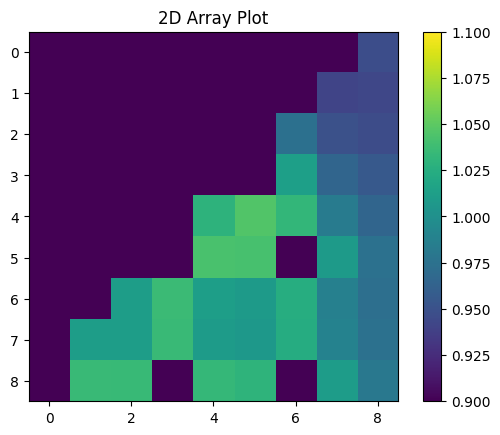

In [54]:
plt.figure()
plt.imshow(dd, cmap='viridis')  # You can change the colormap if desired
plt.title('2D Array Plot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.clim([0.9,1.1])
plt.show()

In [55]:
import os
import re
 
def delete_runtime_files(directory='.', file_list=[]):
    """
    Deletes files matching specific patterns in the specified directory.
   
    Deletes:
    - Files with a .xml extension
    - Files containing 'statepoint' in their name
    - Files containing 'summary' followed by any characters in their name
    - The file named 'tallies.out'
    - Files in the provided `file_list`
   
    Parameters:
    directory (str): The directory to search for files. Defaults to the current directory.
    file_list (list): A list of specific file paths to delete.
    """
   
    # Regular expressions for matching filenames
    statepoint_pattern = re.compile(r'.*statepoint.*')  # Matches any filename containing 'statepoint'
    summary_pattern = re.compile(r'summary.*')         # Matches any filename starting with 'summary'
 
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
       
        # Check if the file matches any deletion criteria
        if (filename.endswith('.xml') or
            statepoint_pattern.match(filename) or
            summary_pattern.match(filename) or
            filename == 'tallies.out'):
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")
 
    # Delete files in the provided file_list
    for file in file_list:
        try:
            os.remove(file)
            print(f"Deleted: {file}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")

In [56]:
delete_runtime_files(directory=my_path)

Deleted: ./mgxs_casl_2B/statepoint.00150.h5
Deleted: ./mgxs_casl_2B/summary.h5
Deleted: ./mgxs_casl_2B/tallies.out
Deleted: ./mgxs_casl_2B/statepoint.01669.h5


In [57]:
model.tallies

[Tally
 	ID             =	1
 	Name           =	power
 	Filters        =	MeshFilter
 	Nuclides       =	
 	Scores         =	['fission', 'nu-fission', 'kappa-fission']
 	Estimator      =	None
 	Multiply dens. =	True,
 Tally
 	ID             =	392
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux', 'total', 'absorption', 'nu-fission', 'fission', 'scatter', 'kappa-fission']
 	Estimator      =	tracklength
 	Multiply dens. =	True,
 Tally
 	ID             =	375
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['nu-fission']
 	Estimator      =	analog
 	Multiply dens. =	True,
 Tally
 	ID             =	376
 	Name           =	
 	Filters        =	CellFilter, EnergyoutFilter
 	Nuclides       =	total
 	Scores         =	['nu-fission']
 	Estimator      =	analog
 	Multiply dens. =	True,
 Tally
 	ID             =	383
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter, E